In [1]:
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity
sns.set_style('darkgrid')
import scipy.stats as sp


In [2]:
point_df = pd.read_csv('points.csv',index_col=0)
# you have to renomalize this or you wont get anywhere near a PDF
point_df['Y'] = point_df['Y']/point_df['Y'].sum()
f = Fitter(point_df)


Text(0.5, 1.0, 'user provided PDF')

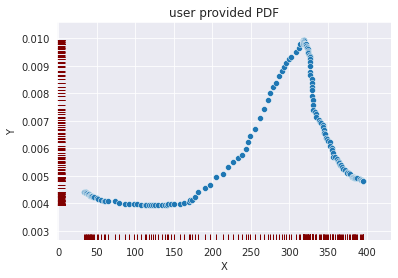

In [3]:
sns.scatterplot(x=point_df.X,y=point_df.Y)
sns.rugplot(x=point_df.X,y=point_df.Y,color='maroon')
plt.title('user provided PDF')

/tmp/ipykernel_57226/3802735747.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  point_df.resampled_x = np.linspace(int(point_df.X.min()), int(point_df.X.max()), point_df.shape[0])


<AxesSubplot:ylabel='Y'>

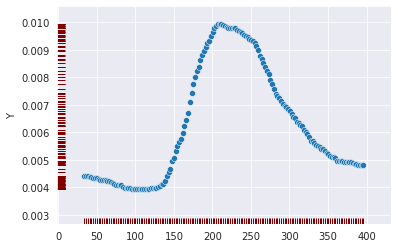

In [4]:
point_df.resampled_x = np.linspace(int(point_df.X.min()), int(point_df.X.max()), point_df.shape[0])
sns.scatterplot(x=point_df.resampled_x, y=point_df.Y)
#sns.scatterplot(x=point_df.X, y=point_df.Y, color='orange')
sns.rugplot(x=point_df.resampled_x,y=point_df.Y,color='maroon')


In [5]:
np.histogram(point_df.resampled_x)

def point_table_to_hist(point_df,num_bins):
    heights = []
    points_per_bin = point_df.shape[0]//num_bins
    for bin_i in range(points_per_bin,point_df.shape[0],points_per_bin):
        last_i = max(0,bin_i - points_per_bin)
        height = point_df.iloc[last_i:bin_i,:].Y.mean()
        heights.append(height)
    return np.array(heights), np.linspace(point_df.X.min(),point_df.X.max(),num_bins)
    
#todo make bins automatic


In [6]:
bin_edges= hist[1]
bin_edges[:-1] > bin_edges[1:]
hist[1]

NameError: name 'hist' is not defined

In [ ]:
point_table_to_hist(point_df, num_bins=20)

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


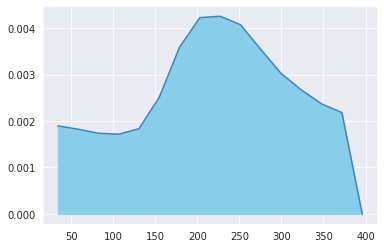

In [7]:
n_b = 16
hist = point_table_to_hist(point_df,num_bins=n_b)


hist_dist = sp.rv_histogram(hist)

X = np.linspace(point_df.X.min(),point_df.X.max(),n_b)

sns.lineplot(hist[1],hist_dist.pdf(X),color='steelblue',alpha=1,)
#(hist[0].size,hist[1].size)
plt.fill_between(x=X,y1=hist_dist.pdf(X),y2=[0]*X.shape[0], color='skyblue', interpolate=True)

Text(0.5, 1.0, 'CDF')

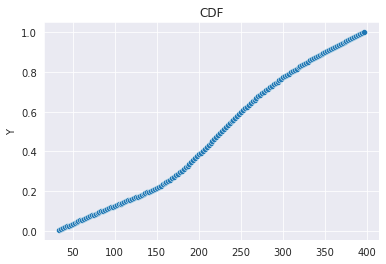

In [8]:
#remove half of the points maybe?
half=point_df.sample(point_df.shape[0]//2)
sns.scatterplot(x=point_df.resampled_x,y=np.cumsum(point_df.Y))
plt.title('CDF')


In [9]:
#roulette wheel sampling
n = 10000
point_df.CDF_y = np.cumsum(point_df.Y)
samples = []

for i in range(n):
    roulette = np.random.uniform(0,1)
    #print(roulette)
    filtered_index = point_df.loc[point_df.CDF_y.apply(lambda x: x < roulette )]
    if filtered_index.shape[0] >= 1:

        samples.append(
                    point_df.iloc[filtered_index.iloc[-1]].X
                                  )       
point_df.samples = pd.Series(samples)

/tmp/ipykernel_57226/4121085393.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  point_df.CDF_y = np.cumsum(point_df.Y)


IndexError: positional indexers are out-of-bounds

In [ ]:
filtered_index.iloc[-1].X

In [ ]:
#by fundamental theorem of calculus, we differentiate CDF to get PDF
diff_pdf = np.diff(np.cumsum(point_df.Y))
renomalized_pdf = diff_pdf/diff_pdf.sum()
sns.lineplot(x=point_df.X.iloc[0:-1],y=renomalized_pdf)
_ = plt.title("diff pdf")

#sns.scatterplot(x=point_df.X.iloc[0:-1],y=renomalized_pdf)

In [ ]:
import scipy.stats as sp
x = []
reg_prob = [0.05,0.1,0.2,0.3,0.4,0.5]
for regulation_probability in reg_prob:
    l = []
    for i in range(1,5):
        l.append( (1-sp.binom(i,regulation_probability).pmf(0) )* 100)
    #pd.Series(l).plot()
    x.append(pd.Series(l))
big_x = pd.DataFrame(x).T
big_x.columns.name = 'yearly probability of regulation'
big_x.index = big_x.index + 2021
big_x.columns = [ f"{i* 100}%" for i in reg_prob ]
#sns.lineplot(big_x)
big_x.plot()
plt.ylabel('probability of regulation (%)')
plt.xlabel('year')
plt.legend(title='yearly probability',loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Compounding probability of regulation')

In [ ]:
#test with np.random
x_lin = np.linspace(0,point_df.X.max(),renomalized_pdf.shape[0])
#fig,ax=plt.subplots(2,1)
fig, ax = plt.subplots()
for i in range(1,22):
    sample = np.random.choice(x_lin, size=10000,p=renomalized_pdf)
    my_kde = sns.kdeplot(sample,bw_method=0.1,bw_adjust=1)
    line = my_kde.lines[0]
    x, y = line.get_data()
#plt.show()
ax.plot(x[x>0], y[x>0])


In [10]:
point_df.X

0       34
1       35
2       36
3       36
4       37
      ... 
155    394
156    395
157    396
158    396
159    395
Name: X, Length: 160, dtype: int64

In [11]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(point_df.X)
dens.fit(fft=True,kernel='gau')
#x = np.linspace(0,1,200) #restrict range to (0,1)
#y = dens.evaluate(point_df.X.iloc[0:-1].to_numpy())
#plt.plot(x_lin,y)
#dens.cdf.sample(10000)
plt.plot(dens.pdf)


AttributeError: 'KDEUnivariate' object has no attribute 'pdf'

In [ ]:
plt.plot(np.diff(dens.cdf))

In [ ]:
sns.displot(x=point_df.X.iloc[0:-1],y=diff_pdf)


1. take in pdf points
2. integrate to approx CDF
3. do sampling from cdf:
    a. pick num between [0,1]. 
    b. go thru all n samples in CDFx. if CDFx_{n+1} > num and CDFx_{n} <= num, then sample x_n. 
    c. repeat until satisfied. 

(array([ 35.,  26.,  19.,   3.,  10.,   4.,   1.,   6.,   7.,   4.,   3.,
          4.,  10.,   9.,   5.,   7.,   2.,   8.,   6.,   2.,   5.,   2.,
          8.,   9.,   7.,   5.,   0.,   5.,   4.,   6.,   8.,   4.,   6.,
         10.,   6.,   9.,   7.,   7.,   9.,  11.,   6.,  12.,  17.,  21.,
          7.,   9.,  61., 109., 161.,  48.,  21.,  24.,  33.,  26.,  23.,
         15.,  17.,  22.,  31.,  38.]),
 array([ 34.        ,  40.03333333,  46.06666667,  52.1       ,
         58.13333333,  64.16666667,  70.2       ,  76.23333333,
         82.26666667,  88.3       ,  94.33333333, 100.36666667,
        106.4       , 112.43333333, 118.46666667, 124.5       ,
        130.53333333, 136.56666667, 142.6       , 148.63333333,
        154.66666667, 160.7       , 166.73333333, 172.76666667,
        178.8       , 184.83333333, 190.86666667, 196.9       ,
        202.93333333, 208.96666667, 215.        , 221.03333333,
        227.06666667, 233.1       , 239.13333333, 245.16666667,
        251.2 

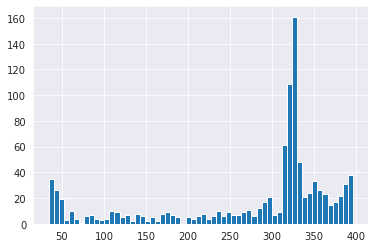

In [19]:
CDFx = np.cumsum(point_df.Y)
#point_df.X.hist(bins=60)
plt.hist(np.random.choice(point_df.X,size=1000, p=point_df.Y),bins=60)

In [20]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.7).fit(point_df)
#kde.score_samples( np.zeros((1, 1)))

In [21]:
#sns.histplot(samples,bins=50)
#sns.scatterplot(x= CDFx.index,y=CDFx.CDFx)

<AxesSubplot:>

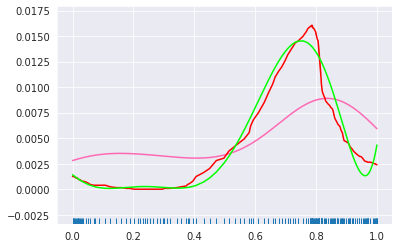

In [263]:
#

smooth = 0.3
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(X[:,np.newaxis])

smpl = kde.score_samples(X[:,np.newaxis])


#sns.kdeplot(x=X,color='maroon',bw=smooth,common_norm=True)
sns.lineplot(x=X,y=np.exp(smpl)/np.exp(smpl).sum(),color='hotpink')
sns.lineplot(x=X,y=Y/Y.sum(),color='red')
sns.rugplot(x=X)
pol = np.polyval(np.polyfit(x=X,y=Y,deg=7),X)
sns.lineplot(x=X,y=pol/pol.sum(),color='lime')

In [273]:
poly_derived_x = np.linspace(0,1,1000)
poly_derived_y = np.polyval(np.polyfit(x=X,y=Y,deg=7),poly_derived_x)
func = opt_beta([50,20],poly_derived_x,poly_derived_y)
bounds = [(0.0006,500),(0.0005,500)]
nak_bound = [(0.00005,100)]
res = differential_evolution(func,bounds=bounds,maxiter=10000,strategy='best1bin')
res

     fun: 0.01155192223611613
     jac: array([-7.44543254e-07,  8.08381145e-07])
 message: 'Optimization terminated successfully.'
    nfev: 981
     nit: 31
 success: True
       x: array([8.95327169, 3.52013282])

<AxesSubplot:>

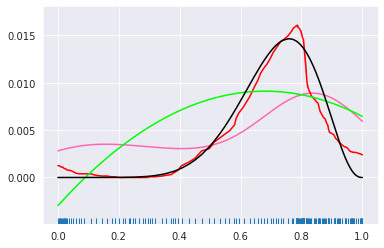

In [277]:
sns.lineplot(x=X,y=np.exp(smpl)/np.exp(smpl).sum(),color='hotpink')
sns.lineplot(x=X,y=Y/Y.sum(),color='red')
sns.rugplot(x=X)
pol = np.polyval(np.polyfit(x=X,y=Y,deg=2),X)
sns.lineplot(x=X,y=pol/pol.sum(),color='lime')

d = beta(res.x[0],res.x[1]).pdf(X)
sns.lineplot(x=X,y=d/d.sum(),color='black')

total_log_prob: 0.0
total_log_prob: 0.0
total_log_prob: 0.0


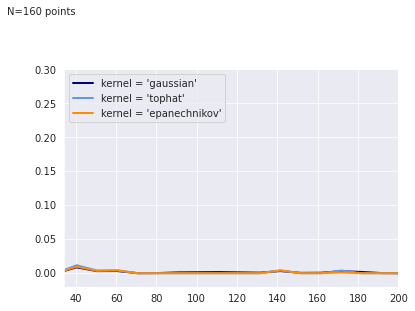

In [198]:
X_plot = np.linspace(0, 1000, 100)[:, np.newaxis]

fig, ax = plt.subplots()
#ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
#        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

X = point_df.X.to_numpy().reshape(-1,1)
for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.8).fit(X)
    log_dens = kde.score_samples(X_plot)
    print(f"total_log_prob: {np.exp(kde.score(X))}")
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(point_df.shape[0]))

ax.legend(loc='upper left')
#ax.plot(point_df.X[:, 0], -0.005 - 0.01 * np.random.random(point_df.X.shape[0]), '+k')z

ax.set_xlim(min(X), X.shape[0]+40)
ax.set_ylim(-0.02, 0.3)
plt.show()

array([-4.51961617e-02, -2.92441267e-02, -1.40893809e-02, -1.40893809e-02,
        2.87547751e-04,  1.39058916e-02,  2.67846444e-02,  3.89425625e-02,
        5.03981663e-02,  5.03981663e-02,  6.11697413e-02,  7.12753395e-02,
        8.07327803e-02,  8.95596524e-02,  1.05390896e-01,  1.24835056e-01,
        1.35121302e-01,  1.46853791e-01,  1.56236263e-01,  1.58507881e-01,
        1.58770108e-01,  1.45088110e-01,  1.25425163e-01,  9.57422142e-02,
        6.68785442e-02,  3.67798399e-02,  1.68225824e-02, -7.26070296e-03,
       -2.97081611e-02, -3.80837778e-02, -5.35982112e-02, -6.06708349e-02,
       -7.03395387e-02, -7.87995900e-02, -8.80616510e-02, -9.61730250e-02,
       -9.90943850e-02, -1.00504720e-01, -1.00589448e-01, -9.94152997e-02,
       -9.53963936e-02, -7.89111026e-02, -6.29489797e-02, -3.82251944e-02,
       -2.86782809e-02, -1.84995260e-02,  3.69497783e-03,  2.82303019e-02,
        9.12193724e-02,  1.46663820e-01,  2.15494159e-01,  2.97849046e-01,
        3.54414953e-01,  

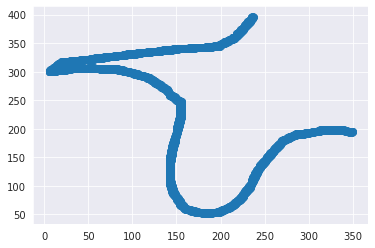

In [25]:
debug_df = pd.read_csv("debug.csv",index_col=0)

debug_df.sort_values(by='X',inplace=True)
#sns.scatterplot(data=debug_df,x='X',y='Y')
def point_table_to_hist(point_df, num_bins):
    point_df.sort_values(by='X',inplace=True)
    heights = []
    x_range = [0]
    points_per_bin = point_df.shape[0]//(num_bins)
    for bin_i in range(points_per_bin, point_df.shape[0], points_per_bin):
        last_i = max(0, bin_i - points_per_bin)
        #print(point_df.iloc[last_i:bin_i, :].X.median())
        x_range.append(point_df.iloc[last_i:bin_i, :].X.median())
        height = point_df.iloc[last_i:bin_i, :].Y.mean()
        heights.append(height)
    return np.array(heights), np.array(x_range) #np.linspace(point_df.X.min(), point_df.X.max(), num_bins)

hist = point_table_to_hist(debug_df,10)
hist_dist = sp.rv_histogram(hist)



#sns.displot(hist_dist.rvs(size=10000),bins=10)
#hist[0].shape,hist[1].shape
plt.scatter(debug_df.X, -debug_df.Y +400)
#sns.rugplot(x=debug_df.X,y=debug_df.Y,color='maroon')


In [16]:
def gradient_descent(objective, derivative, bounds, n_iter, step_size):
    # generate an initial point
    solution = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # run the gradient descent
    for i in range(n_iter):
        # calculate gradient
        gradient = derivative(solution)
        # take a step
        solution = solution - step_size * gradient
        # evaluate candidate point
        solution_eval = objective(solution)
        # report progress
        print('>%d f(%s) = %.5f' % (i, solution, solution_eval))
    return [solution, solution_eval]

In [10]:
from scipy.stats import beta, nakagami
from scipy.optimize import curve_fit,differential_evolution
from scipy.special import rel_entr
from sklearn.preprocessing import MinMaxScaler

In [206]:
scaler = MinMaxScaler()
point_df.t_X = scaler.fit_transform(point_df.X.values.reshape(-1, 1))
X = point_df.t_X[:,0]
Y = scaler.fit_transform(point_df.Y.values.reshape(-1, 1))[:,0]

def opt_beta(a,X,Y):
    return lambda a: np.sqrt(np.sum((beta(a[0],a[1]).cdf(X)-np.cumsum(Y)/np.sum(Y))**2)/X.shape[0])# + 0.5*rel_entr(Y,beta(a,b).pdf(X))).sum()

#lambda a,b: np.sqrt(np.sum((beta(a,b).pdf(X)-Y)**2)/X.shape[0])

#lambda a:  
#np.sqrt(np.sum((beta(a[0],a[1]).pdf(X)-Y)**2)/X.shape[0])
##
def opt_nakagami(a,X,Y):
    return lambda a: np.sqrt(np.sum((nakagami(a).cdf(X)-np.cumsum(Y)/np.sum(Y))**2)/X.shape[0])#(0.5*rel_entr(nakagami(a).pdf(X),Y) + 0.5*rel_entr(Y,nakagami(a).pdf(X) ) ).max()#


In [101]:
func = opt_beta([50,20],X,Y)
bounds = [(0.0006,500),(0.0005,500)]
nak_bound = [(0.00005,100)]
res = differential_evolution(func,bounds=bounds,maxiter=10000,strategy='best1bin')
res

     fun: 0.04971698488887394
     jac: array([-3.78863576e-07,  9.18709477e-07])
 message: 'Optimization terminated successfully.'
    nfev: 759
     nit: 23
 success: True
       x: array([30.41969379,  8.11546262])

In [102]:
func = opt_beta([50,20],X,Y)
rel_entr(beta(1/2,0.3).pdf(X+0.0001),Y)

array([ 1.24047274e+02,  1.63419832e+01,  1.06934223e+01,  1.08831115e+01,
        8.45278642e+00,  7.19594933e+00,  6.25028942e+00,  5.56792015e+00,
        5.16635828e+00,  5.29416063e+00,  4.86710984e+00,  4.51885465e+00,
        4.34545649e+00,  4.21618071e+00,  3.80074331e+00,  3.45605761e+00,
        3.33636832e+00,  3.31431823e+00,  3.15413677e+00,  3.01884442e+00,
        2.79302586e+00,  2.46281985e+00,  2.63230806e+00,  2.71266208e+00,
        2.57866803e+00,  2.88299077e+00,  2.81133768e+00,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,             inf,             inf,
                   inf,             inf,  2.39977704e+00,  2.38461341e+00,
        2.36658538e+00,  1.98872116e+00,  1.77355263e+00,  1.62004204e+00,
        1.41572599e+00,  1.33715469e+00,  1.15725309e+00,  9.22579955e-01,
        7.87949700e-01,  6.84621482e-01,  5.27636459e-01,  4.95729423e-01,
        3.97470494e-01,  

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

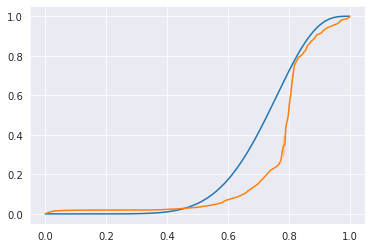

In [278]:
sns.lineplot(X,beta(res.x[0],res.x[1]).cdf(X))
sns.lineplot(X,np.cumsum(Y)/np.sum(Y))
#a,b,loc,scale = beta.fit(X+0.0000001)
#sns.lineplot(X,beta(loc,scale).pdf(X))

#sns.lineplot(point_df.X,point_df.Y)

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

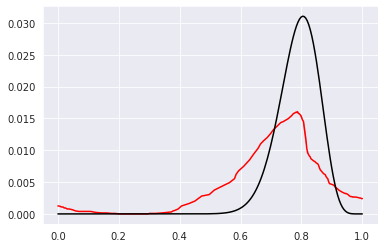

In [105]:
#sns.lineplot(X,beta(res.x[0],res.x[1]).pdf(X))
sns.lineplot(X,Y/np.sum(Y),color='red')
xax = np.linspace(0,1,200)
yax = beta(res.x[0],res.x[1]).pdf(xax)/ beta(res.x[0],res.x[1]).pdf(xax).sum()
sns.lineplot(xax,yax,color='black')

/home/owleyes/anaconda3/envs/stat/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

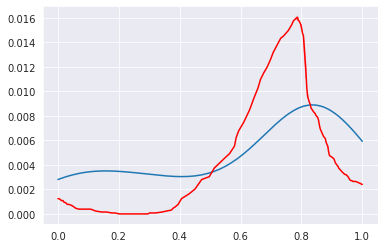

In [212]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.15).fit(X[:,np.newaxis])
smpl = kde.score_samples(X[:,np.newaxis])
sns.lineplot(x=X,y=np.exp(smpl)/np.sum(np.exp(smpl)))
sns.lineplot(X,Y/np.sum(Y),color='red')


In [205]:
X[:,np.newaxis].shape

(160, 1, 1)

In [176]:
np.array(X).shape

(160,)

In [30]:
point_df.shape

(160, 2)

In [9]:
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", a.value, b.value)


NameError: name 'prob' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 616


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

A = np.linspace(1,50,200)
B = np.linspace(1,50,200)
Z = np.ones(shape=(200,200))
for i in range(Z.shape[0]):
    for j in range(Z.shape[0]):
        Z[i,j] = beta(res.x[0],res.x[1]).pdf([A[i],B[j]])#f([A[i],B[j]])


#offline.iplot(dict(data=[go.Surface(x=z=Z, x=A, y=B)]))

ERROR! Session/line number was not unique in database. History logging moved to new session 623


In [87]:
fig = go.Figure(data=[go.Surface(z=Z, x=A, y=B)])
#fig.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Beta Loss Function', autosize=True,
                  margin=dict(l=65, r=50, b=65, t=90))
#go.Surface(z=np.ones(A.shape[0]),x=[30.42111583]*A.shape[0],  y=[8.11582663]*A.shape[0])
fig.write_html('contour_CDF.html')

In [89]:
fig.show()

In [203]:
from fitter import get_common_distributions
hist = point_table_to_hist(point_df,10)
hist_dist = sp.rv_histogram(hist)

samples = hist_dist.rvs(size=1000)
np.min(samples)

34.30368084257507

,sumsquare_error,aic,bic,kl_div
genhalflogistic,0.000113,1188.141700,-15972.059773,0.080510
beta,0.000120,1191.332744,-15908.859520,0.086914
nakagami,0.000139,1223.916201,-15769.222507,0.108333
truncexpon,0.000234,1215.860656,-15245.853522,0.164907
halfgennorm,0.000773,1284.848002,-14052.294266,0.581162


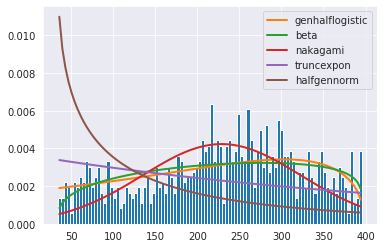

In [209]:
f = Fitter(samples,distributions=["halfgennorm","nakagami",'genhalflogistic','truncexpon','beta'])
f.fit()
f.summary()

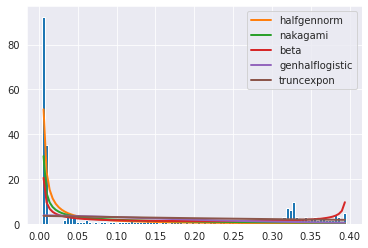

In [208]:
summ = f.summary()
f

In [16]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

X = np.linspace(np.min(hist_dist.rvs(size=1000)),np.max(hist_dist.rvs(size=1000)),25)

trace2 = go.Histogram(x=hist_dist.rvs(size=1000),nbinsx=10,
                      name='Input Distribution',opacity=0.6,histnorm='probability density')
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace2)


for pdf in pdf_dict.keys():
    trace = go.Scatter(x=X,y=pdf_dict[pdf], name=f'{pdf} best fit')
    fig.add_trace(trace,secondary_y=True)
fig.update_layout(bargap=0.01)
fig.show()

NameError: name 'pdf_dict' is not defined

In [17]:
import scipy.stats
dist = scipy.stats.nakagami
params = f.fitted_param['nakagami']
X = np.linspace(10,400,25)
pdf_fitted = dist.pdf(X,*params)

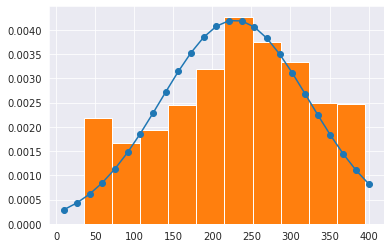

In [18]:
plt.plot(X, pdf_fitted, 'o-')
plt.hist(samples,density=True)
plt.show()

ValueError: Must pass non-zero number of levels/codes

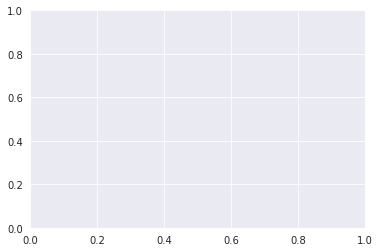

In [19]:
sns.kdeplot(hist_dist.rvs(size=10000),bw_adjust=0.7,multiple='stack')

In [ ]:
_=plt.hist(hist_dist.rvs(size=1000),bins=16)

In [ ]:
hist_dist.